Ridge best params: {'ridge__alpha': np.float64(5.623413251903491), 'poly__degree': 1}
Ridge CV R²: 0.6115 ± 0.0123
Ridge test R²: 0.5759

Running RandomForest RandomizedSearch...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomForest best params: {'rf__n_estimators': 400, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'log2', 'rf__max_depth': 20}
RandomForest CV R²: 0.8179 ± 0.0065
RandomForest test R²: 0.8166

Running LightGBM RandomizedSearch...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM best params: 

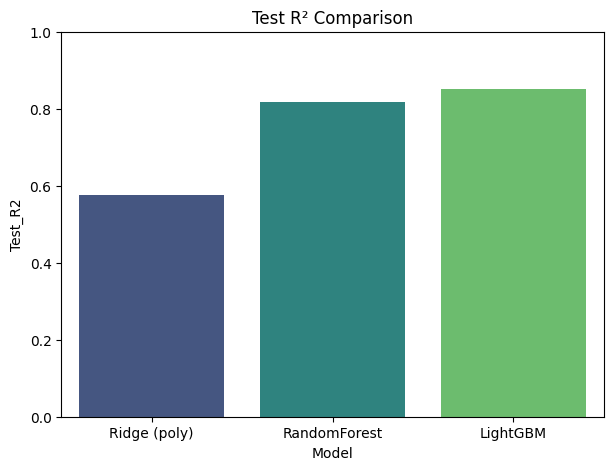

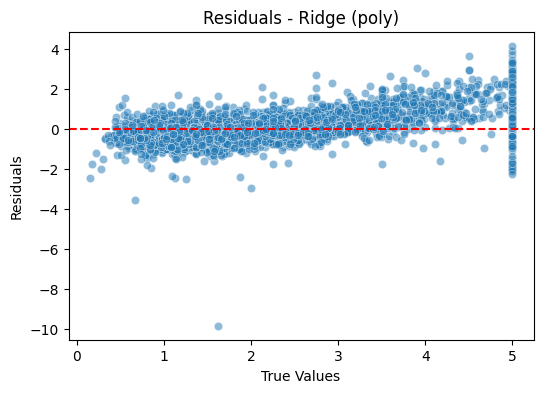

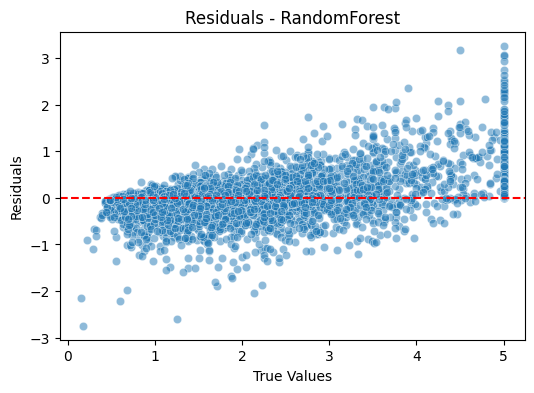

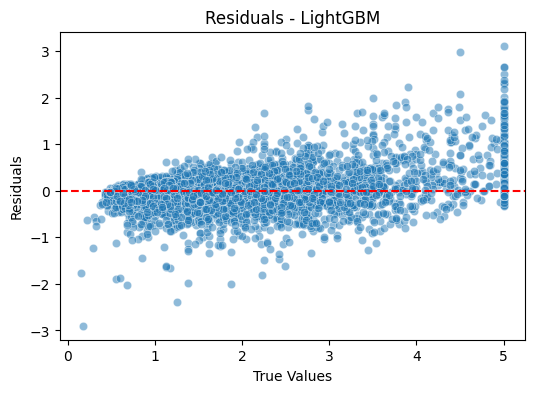

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy.stats import randint, uniform
import lightgbm as lgb

RANDOM_STATE = 42
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 1) Load data
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

print("Shape:", df.shape)
print(df.head())

# 2) Train/test split (keep test unseen for final eval)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)


# 3) Ridge and Polynomial pipeline 

ridge_pipe = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),  
    ("scaler", StandardScaler()),  
    ("ridge", Ridge(random_state=RANDOM_STATE))
])

ridge_param_grid = {
    "poly__degree": [1, 2], 
    "ridge__alpha": np.logspace(-6, 3, 25) 
}

ridge_gs = RandomizedSearchCV(  
    ridge_pipe,
    param_distributions=ridge_param_grid,
    n_iter=25,
    scoring="r2",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\nFitting Ridge (polynomial) RandomizedSearch...")
ridge_gs.fit(X_train, y_train)
best_ridge = ridge_gs.best_estimator_
print("Ridge best params:", ridge_gs.best_params_)

# Cross-validation scores
ridge_cv_scores = cross_val_score(best_ridge, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1)
print(f"Ridge CV R²: {ridge_cv_scores.mean():.4f} ± {ridge_cv_scores.std():.4f}")

y_pred_ridge = best_ridge.predict(X_test)
ridge_test_r2 = r2_score(y_test, y_pred_ridge)
print(f"Ridge test R²: {ridge_test_r2:.4f}")


# 4) Random Forest 

rf_pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

rf_param_dist = {
    "rf__n_estimators": [200, 400, 800],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", 0.3, 0.5, None]
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=30, 
    scoring="r2",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("\nRunning RandomForest RandomizedSearch...")
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("RandomForest best params:", rf_search.best_params_)

rf_cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1)
print(f"RandomForest CV R²: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

y_pred_rf = best_rf.predict(X_test)
rf_test_r2 = r2_score(y_test, y_pred_rf)
print(f"RandomForest test R²: {rf_test_r2:.4f}")


# 5) LightGBM 

lgb_pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("lgb", lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

lgb_param_dist = {
    "lgb__n_estimators": [100, 200, 500],
    "lgb__learning_rate": [0.01, 0.05, 0.1],
    "lgb__max_depth": [-1, 5, 10],
    "lgb__num_leaves": [31, 63, 127],
    "lgb__min_child_samples": [20, 30, 50]
}

lgb_search = RandomizedSearchCV(
    lgb_pipe,
    param_distributions=lgb_param_dist,
    n_iter=25,
    scoring="r2",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("\nRunning LightGBM RandomizedSearch...")
lgb_search.fit(X_train, y_train)
best_lgb = lgb_search.best_estimator_
print("LightGBM best params:", lgb_search.best_params_)

lgb_cv_scores = cross_val_score(best_lgb, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1)
print(f"LightGBM CV R²: {lgb_cv_scores.mean():.4f} ± {lgb_cv_scores.std():.4f}")

y_pred_lgb = best_lgb.predict(X_test)
lgb_test_r2 = r2_score(y_test, y_pred_lgb)
print(f"LightGBM test R²: {lgb_test_r2:.4f}")


# 6) Summarize results

results = pd.DataFrame([
    {"Model": "Ridge (poly)", "CV_R2_mean": ridge_cv_scores.mean(), "CV_R2_std": ridge_cv_scores.std(), "Test_R2": ridge_test_r2},
    {"Model": "RandomForest", "CV_R2_mean": rf_cv_scores.mean(), "CV_R2_std": rf_cv_scores.std(), "Test_R2": rf_test_r2},
    {"Model": "LightGBM", "CV_R2_mean": lgb_cv_scores.mean(), "CV_R2_std": lgb_cv_scores.std(), "Test_R2": lgb_test_r2}
]).set_index("Model")

print("\n=== Summary (R²) ===")
print(results)
plt.figure(figsize=(7,5))
sns.barplot(data=results, x="Model", y="Test_R2", palette="viridis")
plt.title("Test R² Comparison")
plt.ylim(0, 1)
plt.show()


def residual_plot(y_true, y_pred, title):
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_true, y=y_true - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Residuals")
    plt.show()

residual_plot(y_test, y_pred_ridge, "Residuals - Ridge (poly)")
residual_plot(y_test, y_pred_rf, "Residuals - RandomForest")
residual_plot(y_test, y_pred_lgb, "Residuals - LightGBM")